In [1]:
from datetime import datetime, timezone
import pytz

utc_dt = datetime.now(timezone.utc) # UTC time
dt = utc_dt.astimezone()
tz = pytz.timezone('Europe/Berlin')
berlin_now = datetime.now(tz)
print(berlin_now)

2022-07-08 16:39:43.096640+02:00


# 0. import libraries, general settings

In [2]:
# first mute future warnings and only then import pandas
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import scipy
import pandas as pd
import scanpy as sc

from matplotlib import pyplot as plt
from matplotlib import cm
import seaborn as sns
from tqdm import tqdm

In [3]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, facecolor='white')

In [4]:
from numpy.random import MT19937
from numpy.random import RandomState, SeedSequence
rs = RandomState(MT19937(SeedSequence(42)))

# 1. Read single-cell data

In [6]:
# adata = sc.read_loom("/g/arendt/data/spongilla_singlecell_dataset/UCSC_files/spongilla_seurat_object_corrected.loom", sparse=True)
# adata.write("../data/spongilla_basic.h5ad")
adata = sc.read('/g/arendt/npapadop/repos/coffe/data/spongilla_basic.h5ad')

# 2. Set up gene annotation

In [9]:
# create a naked gene_id column to merge on
adata.var['gene_id'] = adata.var.index.str.split().str[0].str.replace('-', '_')
adata.var['legacy name'] = adata.var.index.values
adata.var.set_index('gene_id', inplace=True)
# read foldseek annotation and keep relevant columns
annot = pd.read_csv("/g/arendt/npapadop/repos/coffe/data/spongilla_lut.tsv", sep='\t')
annot_nodoubl = annot.sort_values('bit score', ascending=False).drop_duplicates('gene_id')
keep = ['gene_id', 'Preferred_name_seq', 'Preferred_name_struct', 'Description_seq', 'Description_struct', 'Function [CC]', 'PFAMs_seq', 'PFAMs_struct']
annot_nodoubl = annot_nodoubl[keep]
adata.var = adata.var.join(annot_nodoubl.set_index('gene_id'), how='left')

/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (6,7,29) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


To facilitate marker gene plotting but also counting the number of annotated genes we will create new columns in the `.var` slot that will hold the sequence based names, structure based names, and combinations thereof, which will be the most comprehensive.

First we'll start by finding the different annotation levels - named genes, described genes, and unannotated genes - both for sequence-based and structure-based annotation.

In [10]:
seq_isnan = adata.var["Preferred_name_seq"].isnull()
seq_missing = adata.var["Preferred_name_seq"] == "-"
seq_no_desc = adata.var["Description_seq"].isnull()
seq_desc_mis = adata.var["Description_seq"] == "-"

struct_isnan = adata.var["Preferred_name_struct"].isnull()
struct_missing = adata.var["Preferred_name_struct"] == "-"
struct_no_desc = adata.var["Description_struct"].isnull()
struct_desc_mis = adata.var["Description_struct"] == "-"

seq_has_name = ~(seq_isnan | seq_missing)
seq_has_desc = ~(seq_no_desc | seq_desc_mis)
struct_has_name = ~(struct_isnan | struct_missing)
struct_has_desc = ~(struct_no_desc | struct_desc_mis)

In [11]:
adata.var['gene_id'] = adata.var.index.values

Now we will combine the masks to build the best sequence annotation by using the gene IDs and the emapper fields

In [12]:
# build best sequence annotation
has_seq_desc_but_no_seq_name = seq_has_desc & ~seq_has_name
seq_unannotated = ~(seq_has_name | has_seq_desc_but_no_seq_name)
seq_named = adata.var["gene_id"][seq_has_name] + " | " + "[" + adata.var["Preferred_name_seq"][seq_has_name] + "]"
seq_described = adata.var["gene_id"][has_seq_desc_but_no_seq_name] + " | [" + adata.var["Description_seq"][has_seq_desc_but_no_seq_name] +"]"
seq_unnamed = adata.var["gene_id"][seq_unannotated]
seq_names = pd.DataFrame(seq_named.append(seq_described).append(seq_unnamed))
seq_names.columns = ['best seq. name']

same for structure-based annotation

In [13]:
# build best structure annotation
has_struct_desc_but_no_struct_name = struct_has_desc & ~struct_has_name
struct_unannotated = ~(struct_has_name | has_struct_desc_but_no_struct_name)
struct_named = adata.var["gene_id"][struct_has_name] + " | (" + adata.var["Preferred_name_struct"][struct_has_name] + ')'
struct_described = adata.var["gene_id"][has_struct_desc_but_no_struct_name] + " | (" + adata.var["Description_struct"][has_struct_desc_but_no_struct_name] + ")"
struct_unnamed = adata.var["gene_id"][struct_unannotated]
struct_names = pd.DataFrame(struct_named.append(struct_described).append(struct_unnamed))
struct_names.columns = ['best struct. name']

Very similarly, we will combine the masks to make the best combination. We will always give precedence to sequence-based annotation, wherever available.

In [14]:
# best overall annotation
# first sequence name, then sequence description
# then structure name, then structure description
has_struct_name_but_no_seq_any = seq_unannotated & struct_has_name
has_struct_desc_but_no_else = seq_unannotated & ~struct_has_name & struct_has_desc
unannotated = ~(seq_has_name | seq_has_desc | struct_has_name | struct_has_desc)

struct_named_no_seq = adata.var["gene_id"][has_struct_name_but_no_seq_any] + " | (" + adata.var["Preferred_name_struct"][has_struct_name_but_no_seq_any] + ")"
struct_desc_nothing_else = adata.var["gene_id"][has_struct_desc_but_no_else] + " | (" + adata.var["Description_struct"][has_struct_desc_but_no_else] + ")"
unnamed = adata.var["gene_id"][unannotated]

best_names = pd.DataFrame(seq_named.append(seq_described).append(struct_named_no_seq).append(struct_desc_nothing_else).append(unnamed))
best_names.columns = ['best name']

Actuall add the annotation to the object:

In [15]:
adata.var = adata.var.join(seq_names)
adata.var = adata.var.join(struct_names)
adata.var = adata.var.join(best_names)

In [16]:
adata.var.drop('gene_id', inplace=True, axis=1)

# Comparing performance

We will look at how many more DEGs we can annotate using the MAF output, and we will do so on the cluster, cell type, and clade level. First we'll read the tables from Supplementary Data S1 [Musser _et al._, 2021](https://www.science.org/doi/10.1126/science.abj2949):

- `DEG_clusters.tsv` is the "Diff. Exp. 42 clusters" tab
- `DEG_celltypes.tsv` is the "Diff. Exp. cell types" tab
- `DEG_clusters.tsv` is the "Cell Type clade genes (OU tests" tab

In [18]:
cluster_DEG = pd.read_csv('/g/arendt/npapadop/repos/coffe/data/DEG_clusters.tsv', sep='\t', decimal=',')
cluster_DEG['gene_id'] = cluster_DEG['Automated Gene Name (in seurat object and some suppl. Figs.)'].str.split().str[0].str.replace('-', '_')
cluster_DEG = cluster_DEG.merge(seq_names, on='gene_id').merge(struct_names, on='gene_id').merge(best_names, on='gene_id')

celltype_DEG = pd.read_csv('/g/arendt/npapadop/repos/coffe/data/DEG_celltypes.tsv', sep='\t', decimal=',')
celltype_DEG['gene_id'] = celltype_DEG['Automated Gene Name (in seurat object and some suppl. Figs.)'].str.split().str[0].str.replace('-', '_')
celltype_DEG = celltype_DEG.merge(seq_names, on='gene_id').merge(struct_names, on='gene_id').merge(best_names, on='gene_id')

clade_DEG = pd.read_csv('/g/arendt/npapadop/repos/coffe/data/DEG_clades.tsv', sep='\t', decimal=',')
clade_DEG['gene_id'] = clade_DEG['Automated Gene Name (in seurat object and some suppl. Figs.)'].str.split().str[0].str.replace('-', '_')
clade_DEG = clade_DEG.merge(seq_names, on='gene_id').merge(struct_names, on='gene_id').merge(best_names, on='gene_id')

From each table we will extract the DEGs per level of annotation (cluster, cell type, clade), and count which proportion of them is annotated using the legacy annotation (phylome+blastp from the Musser _et al._ paper) versus the MAF pipeline.

In [19]:
def parse_table(df, slot):
    df = df[df[slot].notna()]
    res = {}
    for category in np.unique(df[slot]):
        tmp = df[df[slot] == category]
        legacy_named = ~tmp['Manually curated gene name'].isnull() | tmp['Automated Gene Name (in seurat object and some suppl. Figs.)'].str.contains(' ')
        seq_named = tmp['best seq. name'].str.contains('\|')
        struct_named = tmp['best struct. name'].str.contains('\|')
        best_named = tmp['best name'].str.contains('\|')
        res[category] = np.array([sum(legacy_named), sum(seq_named), sum(struct_named), sum(best_named)]) / len(tmp)
    annot = pd.DataFrame(res).T
    annot.columns = ['legacy', 'emapper only', 'FoldSeek only', 'emapper+FoldSeek']
    return annot

In [20]:
cluster_annot = parse_table(cluster_DEG, 'Cluster #')
celltype_annot = parse_table(cluster_DEG, 'Cell Type')
clade_annot = parse_table(clade_DEG, 'Clade with changed optimal expression')

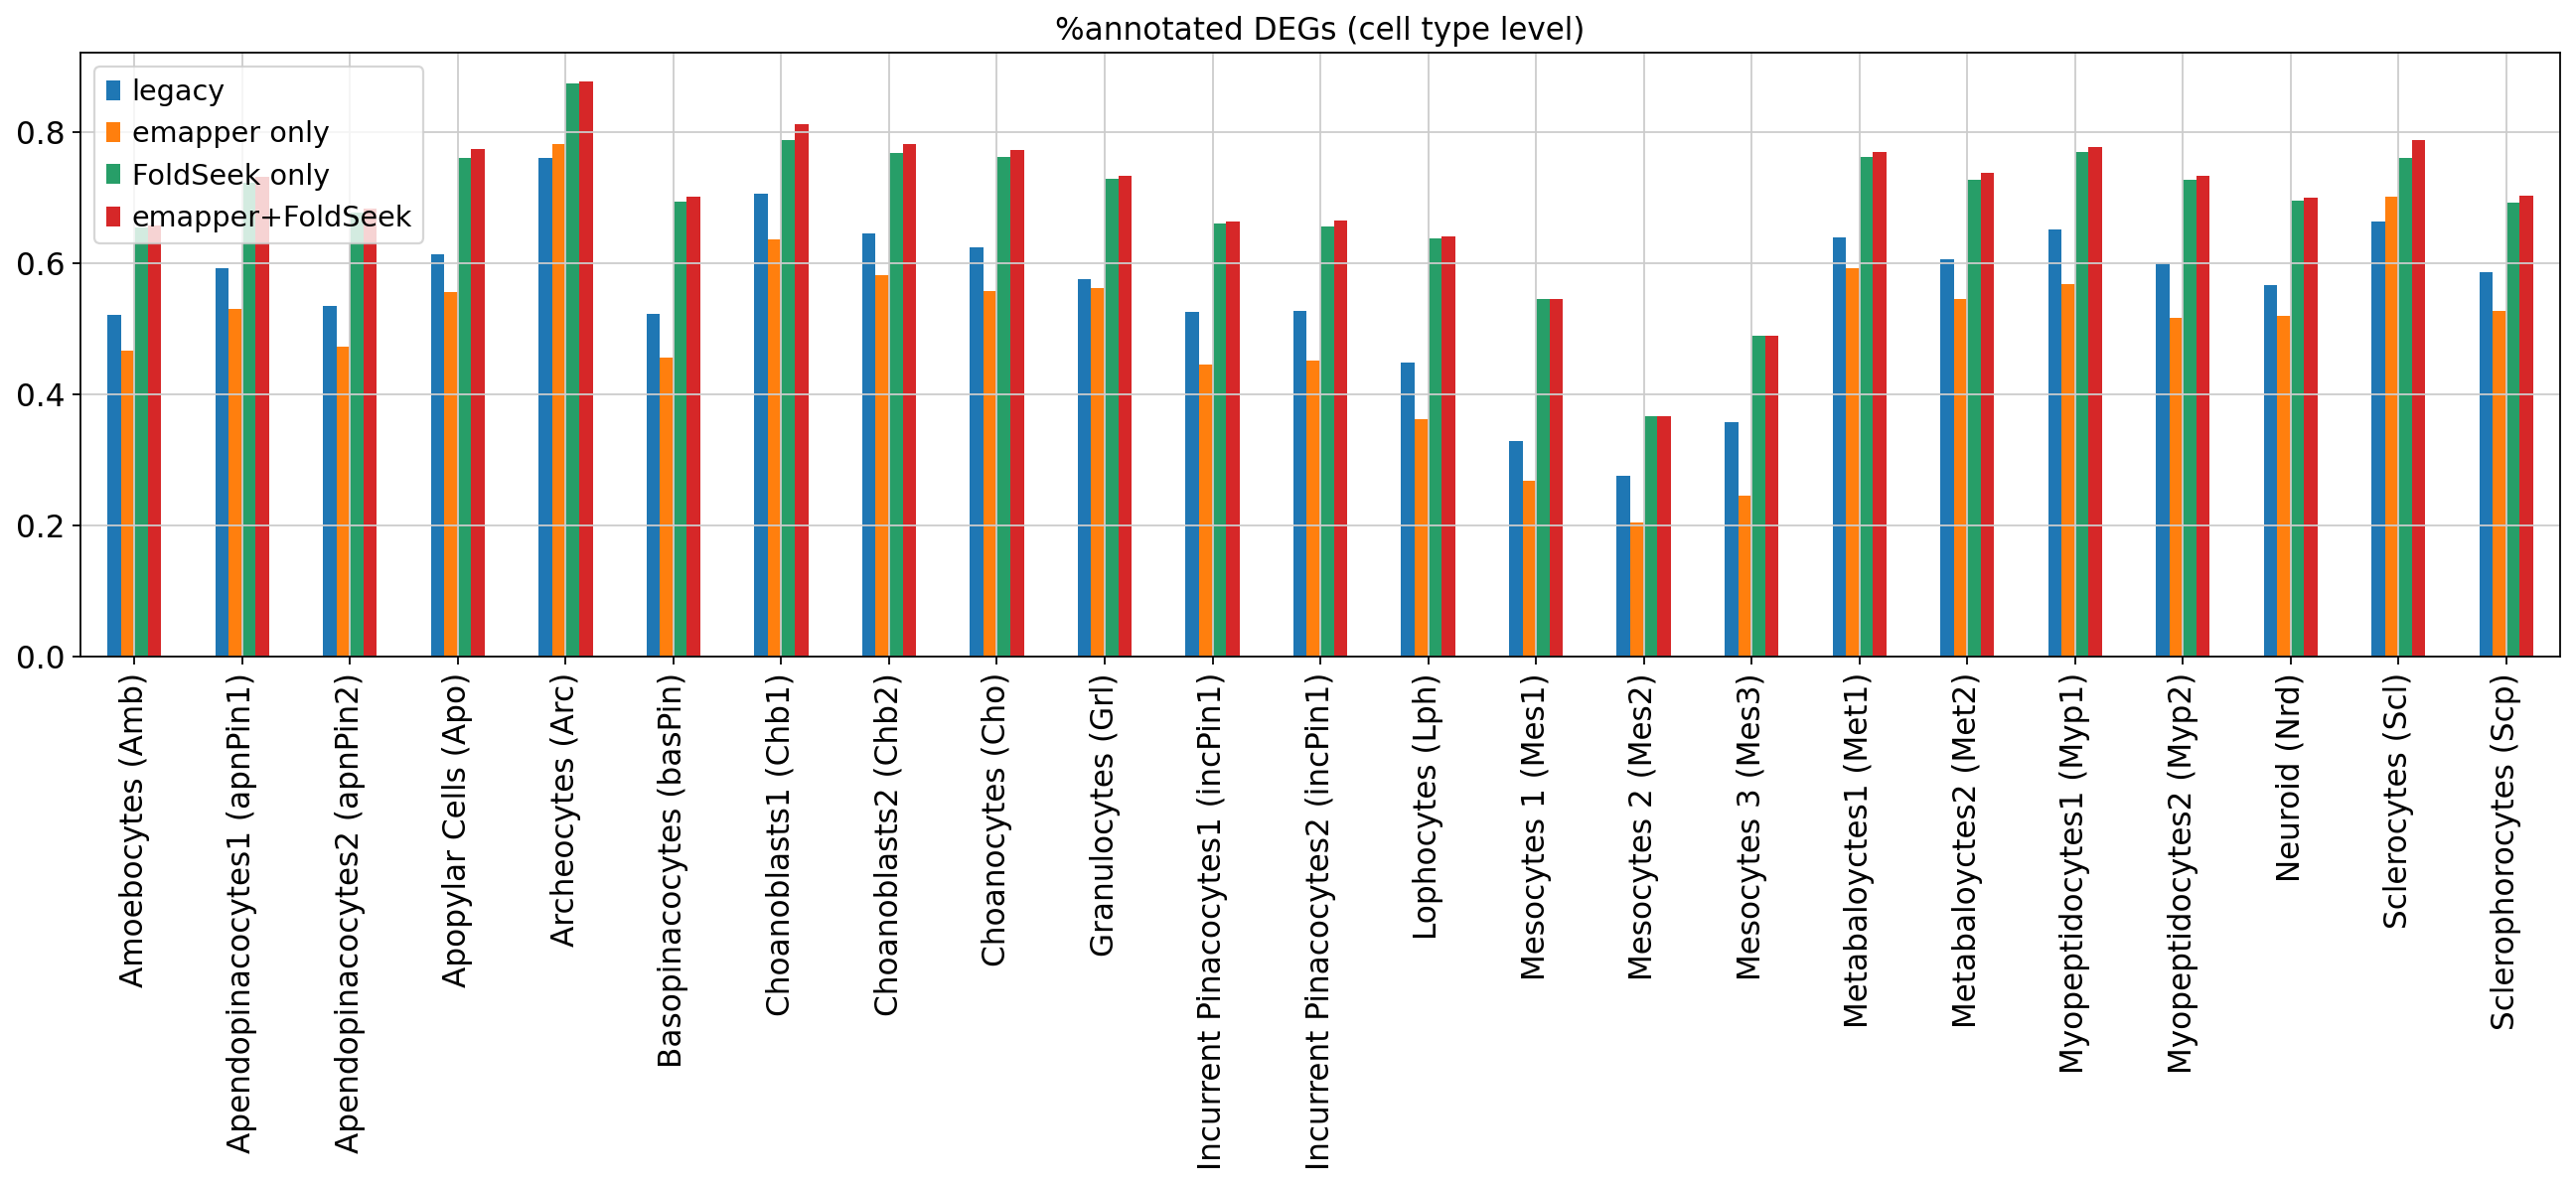

In [29]:
# fig, ax = plt.subplots(figsize=(30, 5))
# cluster_annot.plot(y=['legacy', 'emapper only', 'FoldSeek only', 'emapper+FoldSeek'], kind='bar', ax=ax);
# ax.set_title('%annotated DEGs (cluster level)')

fig, ax = plt.subplots(figsize=(20, 5))
celltype_annot.plot(y=['legacy', 'emapper only', 'FoldSeek only', 'emapper+FoldSeek'], kind='bar', ax=ax);
ax.set_title('%annotated DEGs (cell type level)')
plt.savefig('./figures/analysis-celltype_DEG.pdf')
# fig, ax = plt.subplots(figsize=(30, 5))
# clade_annot.plot(y=['legacy', 'emapper only', 'FoldSeek only', 'emapper+FoldSeek'], kind='bar', ax=ax);
# ax.set_title('%annotated DEGs (clade level)');

Maybe a better way to get a feeling is to compare %enrichment. We will extract it from the peaks and plot it separately:

In [22]:
n_clust = len(cluster_annot)
n_cellt = len(celltype_annot)
n_clade = len(clade_annot)
total_categories = n_clust + n_cellt + n_clade

maf_enrichment_clust = list(cluster_annot['emapper+FoldSeek'] / cluster_annot['legacy'] - 1)
maf_enrichment_cellt = list(celltype_annot['emapper+FoldSeek'] / celltype_annot['legacy'] - 1)
maf_enrichment_clade = list(clade_annot['emapper+FoldSeek'] / clade_annot['legacy'] - 1)

blastp_enrichment_clust = list(cluster_annot['legacy'] / cluster_annot['emapper only'] - 1)
blastp_enrichment_cellt = list(celltype_annot['legacy'] / celltype_annot['emapper only'] - 1)
blastp_enrichment_clade = list(clade_annot['legacy'] / clade_annot['emapper only'] - 1)

best_enrichment_clust = list(cluster_annot['emapper+FoldSeek'] / cluster_annot['emapper only'] - 1)
best_enrichment_cellt = list(celltype_annot['emapper+FoldSeek'] / celltype_annot['emapper only'] - 1)
best_enrichment_clade = list(clade_annot['emapper+FoldSeek'] / clade_annot['emapper only'] - 1)

enrichment = maf_enrichment_clust + maf_enrichment_cellt + maf_enrichment_clade + blastp_enrichment_clust + blastp_enrichment_cellt + blastp_enrichment_clade + best_enrichment_clust + best_enrichment_cellt + best_enrichment_clade
tool = ['CoFFE to BLASTp'] * total_categories + ['BLASTp to EggNOG-mapper'] * total_categories + ['CoFFE to EggNOG-mapper'] * total_categories
single_level = ['cluster'] * n_clust + ['cell type'] * n_cellt + ['clade'] * n_clade
level = single_level + single_level + single_level

In [23]:
summary = pd.DataFrame({'%enrichment': np.array(enrichment) * 100, 'comparison': tool, 'level': level})

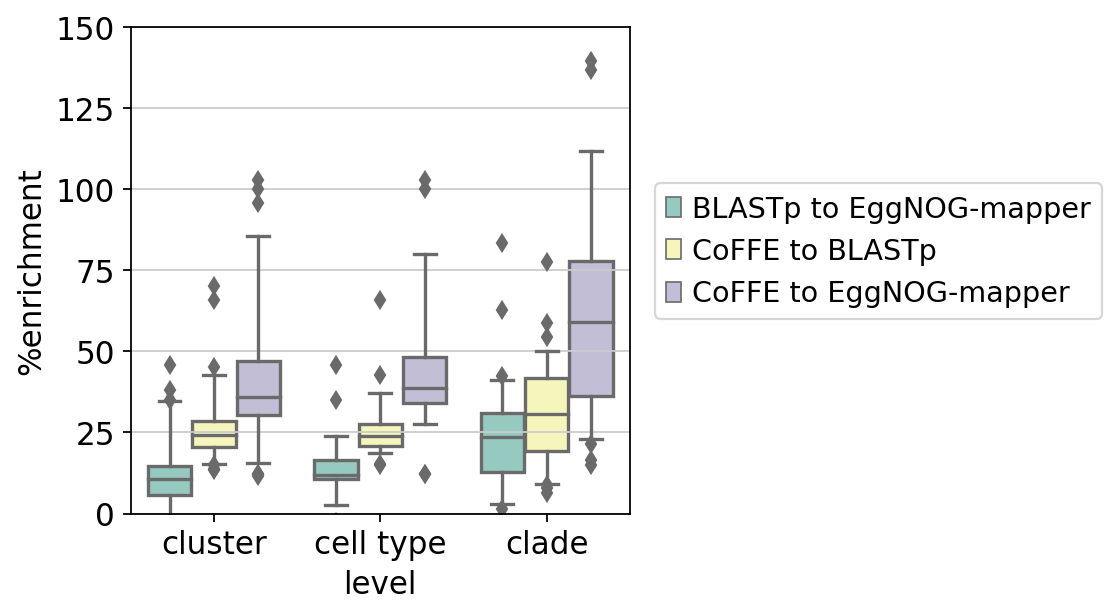

In [24]:
fig, ax = plt.subplots()
sns.boxplot(data=summary, x='level', y='%enrichment', hue='comparison', ax=ax, hue_order=['BLASTp to EggNOG-mapper', 'CoFFE to BLASTp', 'CoFFE to EggNOG-mapper'], palette=cm.Set3.colors[:3], whis=[5, 95])
ax.legend(loc=[1.05, 0.4])
ax.set_ylim(0, 150)
plt.savefig('./figures/analysis-enrichment.pdf')

Takeaways:
- using BLASTp on top of emapper gives us 10-20% more hits.
- using the CoFFE pipeline represents a 40-50% enrichment compared to emapper only, and a 25-30% enrichment to the realistic annotation pipeline of emapper + BLASTp

let's just plot the raw numbers for that:

In [25]:
raw = pd.concat([cluster_annot, celltype_annot, clade_annot], keys=['cluster', 'cell type', 'clade'])
raw.reset_index(inplace=True)
raw.columns = ['level', 'category', 'EggNOG-mapper + BLASTp', 'EggNOG-mapper', 'CoFFE', 'CoFFE + sequence']

In [26]:
melted = pd.melt(raw, id_vars='level', value_vars=['EggNOG-mapper + BLASTp', 'EggNOG-mapper', 'CoFFE'])

In [27]:
melted = melted.append({'level': 'whole organism', 'variable': 'EggNOG-mapper', 'value': 17990/41943}, ignore_index=True)
melted = melted.append({'level': 'whole organism', 'variable': 'CoFFE', 'value': 25232/41943}, ignore_index=True)
melted = melted.append({'level': 'whole organism', 'variable': 'EggNOG-mapper + BLASTp', 'value': (17990 + 682)/41943}, ignore_index=True)
# melted.append(['whole organism', 'CoFFE', ])
# melted.append(['whole organism', 'EggNOG-mapper + BLASTp', ])
# melted['level'] = melted['level'].str.replace(' ', '\n')

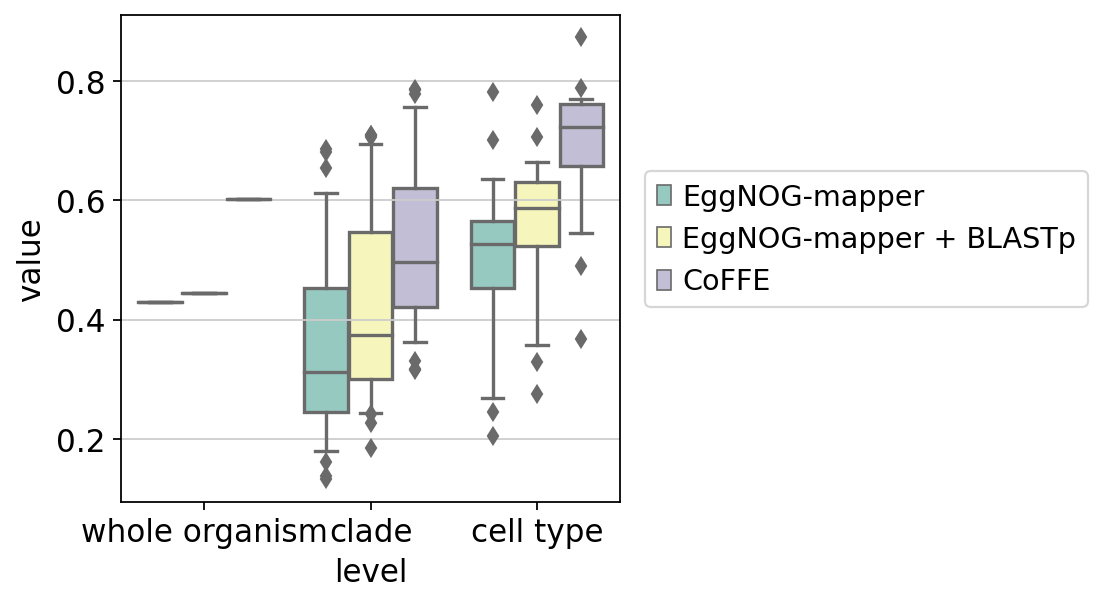

In [28]:
fig, ax = plt.subplots()
sns.boxplot(data=melted, x='level', y='value', hue='variable', ax=ax, hue_order=['EggNOG-mapper', 'EggNOG-mapper + BLASTp', 'CoFFE'], 
            palette=cm.Set3.colors[:3], whis=[5, 95], order=['whole organism', 'clade', 'cell type'])
ax.legend(loc=[1.05, 0.4])
# ax.set_ylim(0, 150)
plt.savefig('./figures/analysis-percent_annotated.pdf')

# Finding new biology

We need to merge the "best name" and the "legacy" names in order to keep track of which information is new; then we will explore the resulting dotplots.

In [161]:
has_name = cluster_DEG['Automated Gene Name (in seurat object and some suppl. Figs.)'].str.contains(' ')

replace = {}
for i,j in zip(cluster_DEG['best name'][has_name].values, cluster_DEG['Automated Gene Name (in seurat object and some suppl. Figs.)'][has_name].values):
    replace[i] = j

cluster_DEG['fusion'] = cluster_DEG['best name'].replace(replace)
adata.var['fusion'] = adata.var['best name'].replace(replace)

In [ ]:
for cluster in cluster_DEG['Cluster #'].unique():
    tmp = cluster_DEG[cluster_DEG['Cluster #'] == cluster].sort_values('Adj. Pval (Bonferonni)')
    keep = tmp['fusion'][:200].str.contains(' ')
    genes_best = tmp['fusion'][:200][keep]
    cell_type = tmp['Cell Type'].unique()
    if len(cell_type) == 0:
        cell_type = cluster
    else:
        if cell_type[0] is np.NaN:
            cell_type = cluster
        else:
            cell_type = '_'.join(cell_type[0].split(' ')[:-1])
#     print(cell_type)
    sc.pl.dotplot(adata, groupby='cell_type', var_names=genes_best, cmap='magma_r', gene_symbols='fusion', swap_axes=True, save=f'cluster_{cell_type}.pdf')

In [31]:
dip = adata.var[adata.var['fusion'].str.contains('dipep', case=False)]['fusion']

In [40]:
bmp = adata.var['fusion'][adata.var['fusion'].str.contains('BMP', case=False)]
tgfbeta = adata.var['fusion'][adata.var['fusion'].str.contains('TGF', case=False)]

In [48]:
curated_tgfbeta = ['c99909_g1', 'c95960_g1', 'c95568_g1', 'c79432_g1']
curated_bmp = ['c111603_g1', 'c42918_g1', 'c50424_g1', 'c88612_g1', 'c99958_g1']
curated = curated_tgfbeta + curated_bmp

In [104]:
adata.var.columns

Index(['legacy name', 'Preferred_name_seq', 'Preferred_name_struct',
       'Description_seq', 'Description_struct', 'Function [CC]', 'PFAMs_seq',
       'PFAMs_struct', 'best seq. name', 'best struct. name', 'best name',
       'fusion'],
      dtype='object')

In [200]:
test = adata.var['fusion'][adata.var['fusion'].str.contains('rho', case=False).fillna(False)]

In [201]:
test

gene_id
c100449_g1             c100449-g1 RTKN2 (Rhotekin) - emapper OG
c101230_g1    c101230-g1 SRGAP3 (SLIT-ROBO Rho GTPase activa...
c101336_g2    c101336-g2 (Inherit from KOG: rho guanine nucl...
c101536_g1    c101536_g1 | [Guanine nucleotide exchange fact...
c101832_g1                                 c101832_g1 | [RHOT2]
c102226_g1    c102226-g1 7-to-3 RAC2,RAC3,RAC1 ras-related C...
c102264_g1                       c102264_g1 | (Rhomboid family)
c102369_g1    c102369-g1 7-to-3 RAC2,RAC3,RAC1 ras-related C...
c102784_g1    c102784-g1 1-to-1 ARHGAP39 Rho GTPase activati...
c102965_g1    c102965-g1 1-to-5 ARHGEF18,AKAP13,ARHGEF2,ARHG...
c103140_g2    c103140-g2 7-to-3 RAC2,RAC3,RAC1 ras-related C...
c103251_g1    c103251-g1 1-to-4 SRGAP1,ARHGAP4,SRGAP3,SRGAP2...
c103493_g1    c103493-g1 1-to-1 ARHGAP19 Rho GTPase activati...
c103502_g1    c103502-g1 1-to-1 ARHGAP4 Rho GTPase activatin...
c103684_g1    c103684-g1 1-to-2 RHOV,RHOU ras homolog family...
c103750_g2    c103750-g2 ARHGAP5

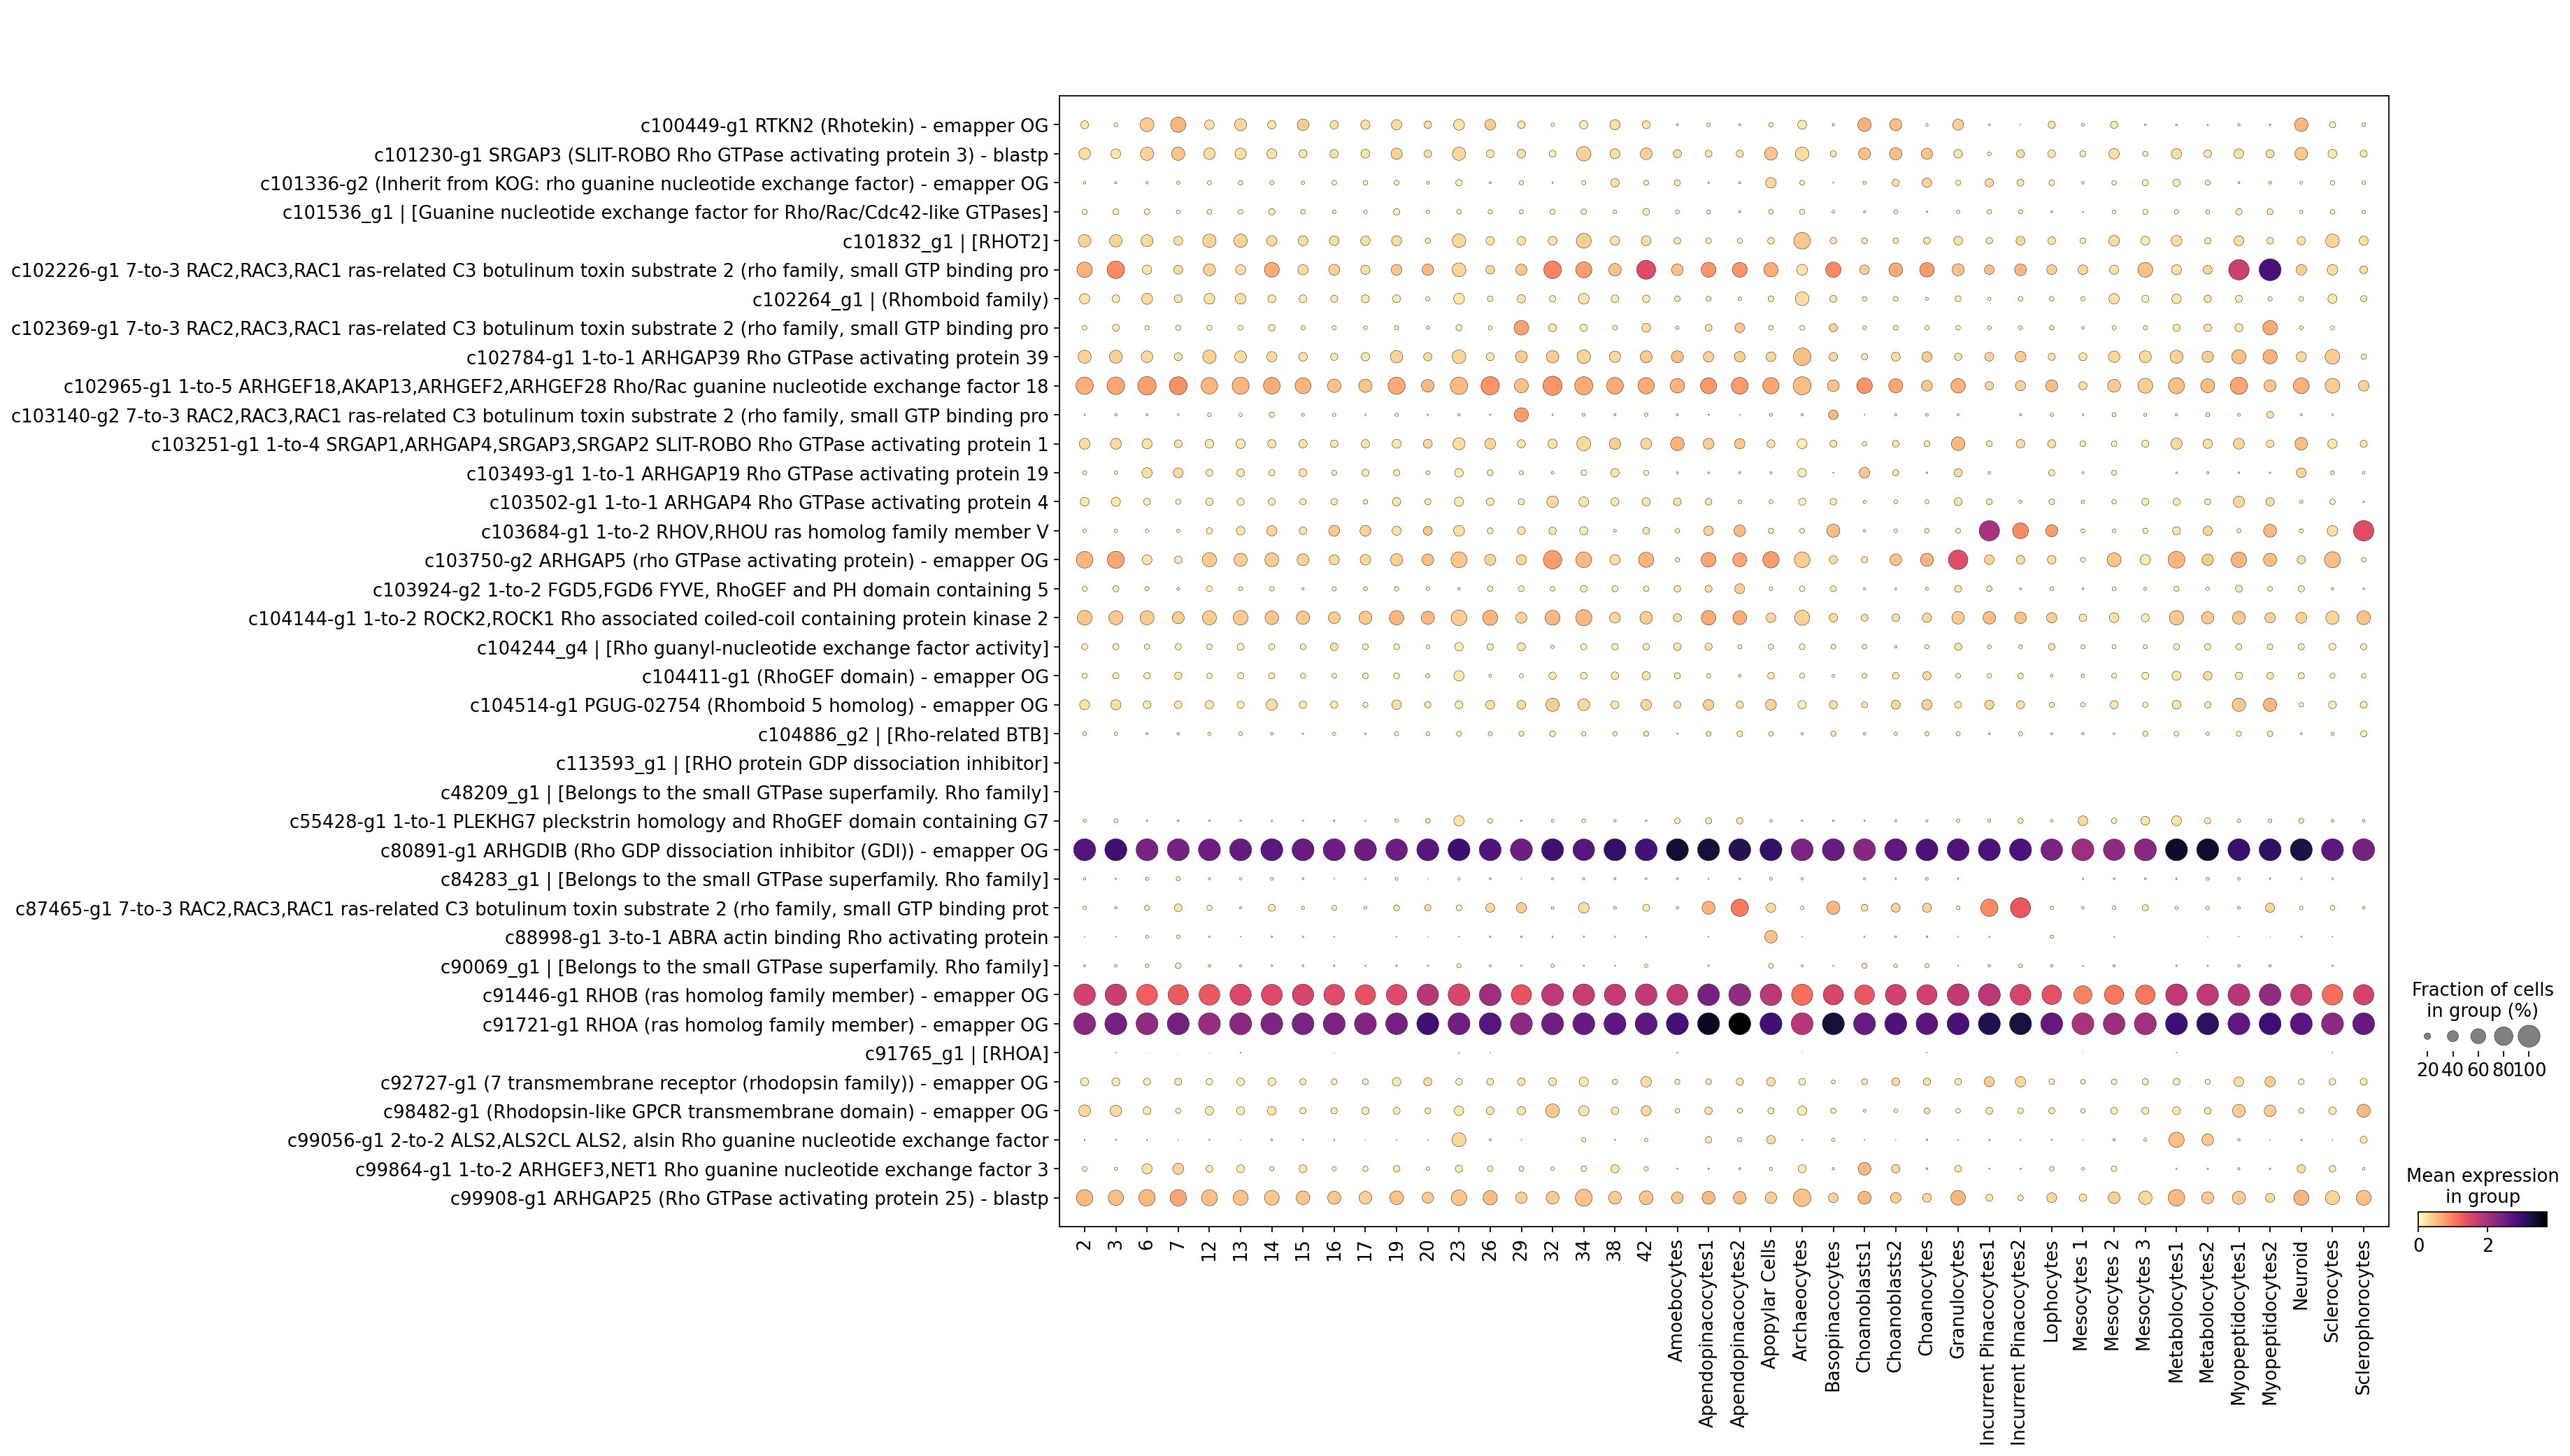

In [202]:
sc.pl.dotplot(adata, groupby='cell_type', var_names=test, gene_symbols='fusion', cmap='magma_r', swap_axes=True)

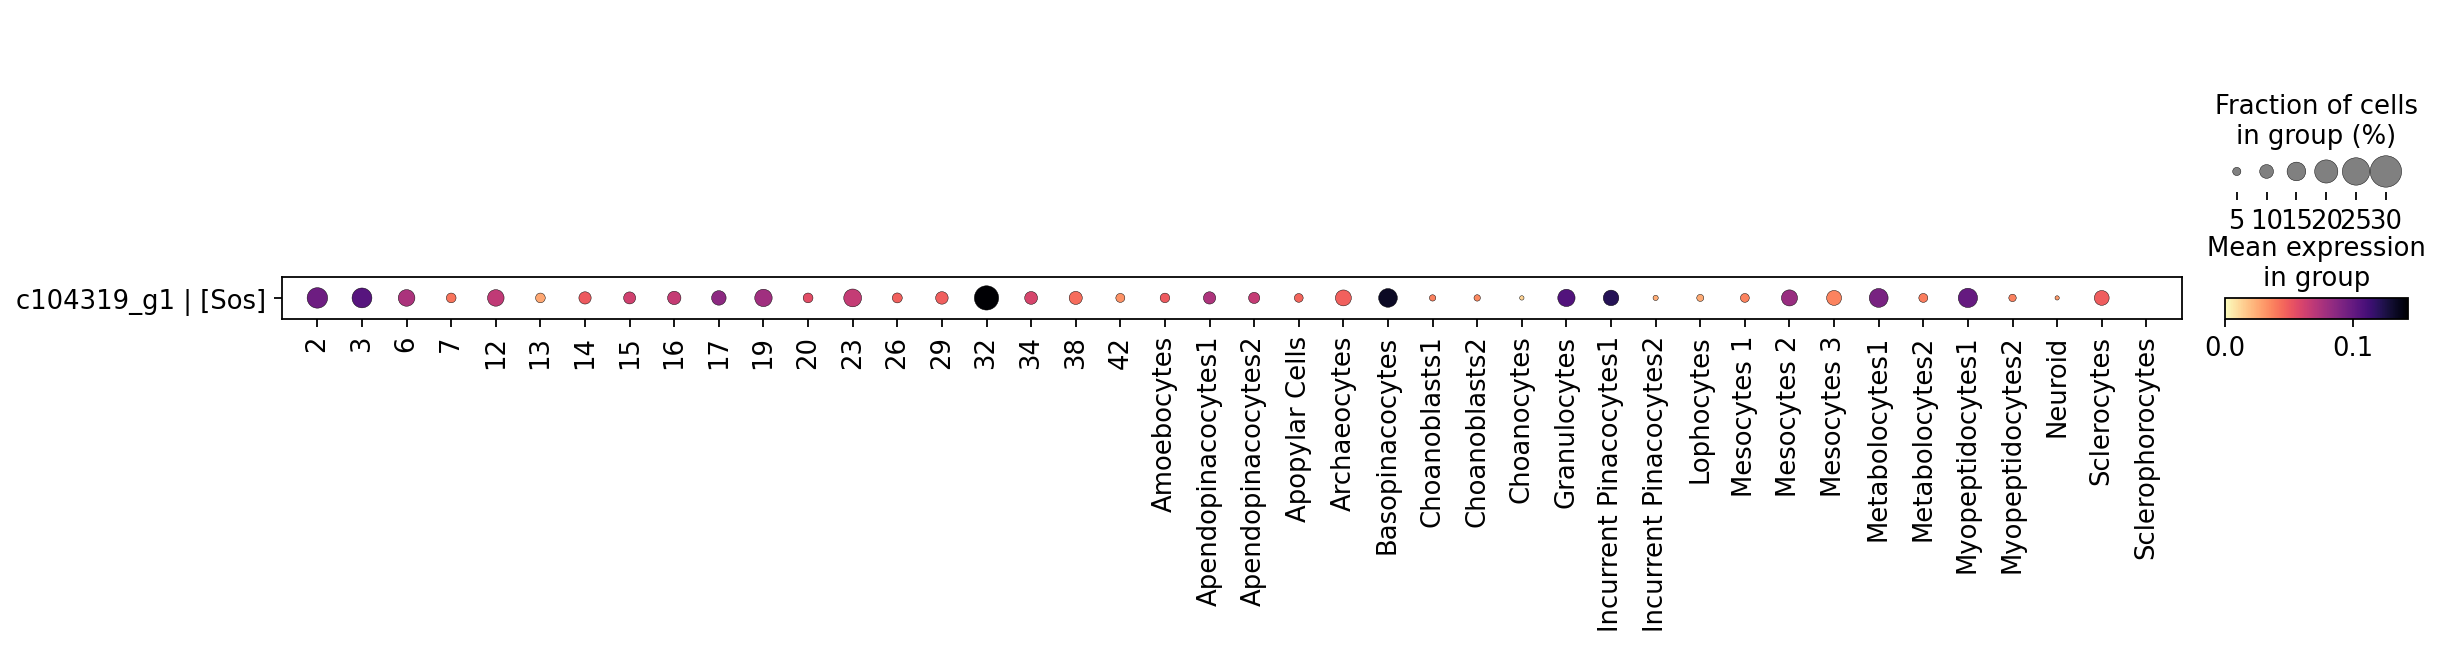

In [117]:
# epithelial barrier
epithelial_barrier = ['c104319_g1']
sc.pl.dotplot(adata, groupby='cell_type', var_names=adata.var['fusion'][epithelial_barrier], gene_symbols='fusion', cmap='magma_r', swap_axes=True)

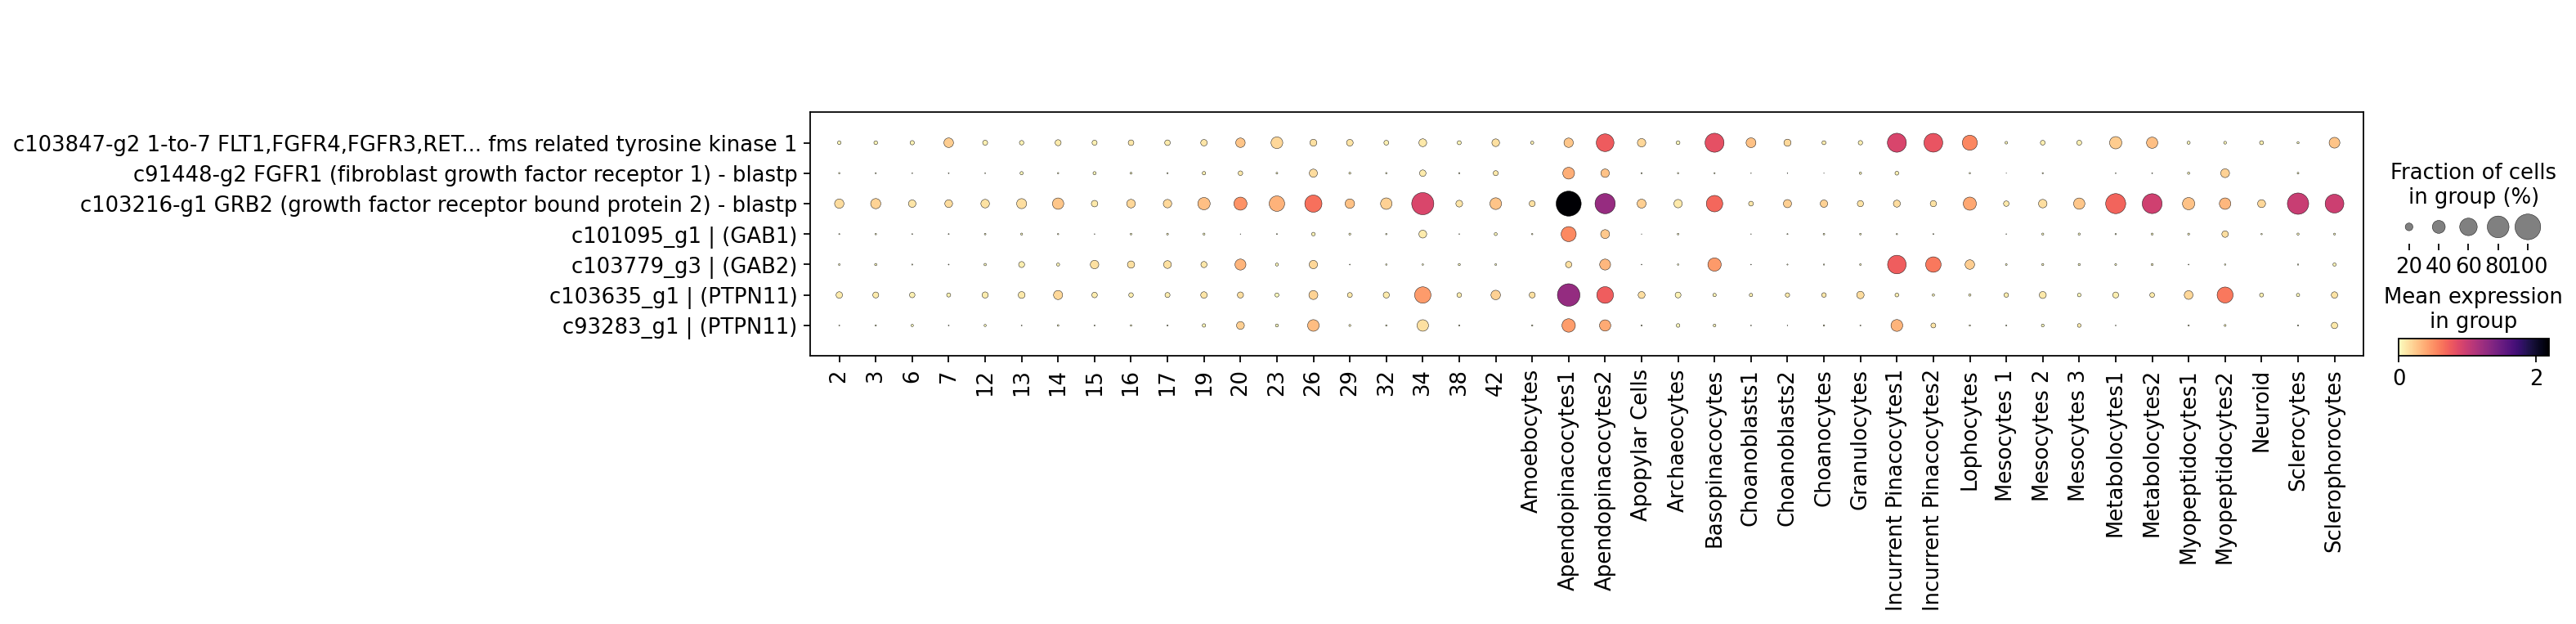

In [97]:
# FGFR/GRB/GAB/PTPN signalling cascade
ptpn = ['c103635_g1', 'c93283_g1']
grb = ['c103216_g1']
fgfr = ['c103847_g2', 'c91448_g2']
gab = ['c101095_g1', 'c103779_g3']

sc.pl.dotplot(adata, groupby='cell_type', var_names=adata.var['fusion'][fgfr + grb + gab + ptpn], gene_symbols='fusion', cmap='magma_r', swap_axes=True)